In [1]:
import struct
import numpy as np
import os
import threading

In [2]:
import matplotlib.pyplot as plt
import healpy as hp
nside = 128
npix = hp.nside2npix(nside)

%matplotlib inline

In [3]:
def getRadialUnitVecs(spherePos):
    unitVecs = np.zeros((len(spherePos),3))
    
    #negative because you want it pointing towards the origin    
    unitVecs[:,0] = -np.multiply(np.cos(spherePos[:,2]),np.sin(spherePos[:,1]))
    unitVecs[:,1] = -np.multiply(np.sin(spherePos[:,2]),np.sin(spherePos[:,1]))
    unitVecs[:,2] = -np.cos(spherePos[:,1])
    
    return unitVecs

In [4]:
def getScalingFactorSquared(radius):
    a= -0.01*radius+1
    return np.power(a,2)

In [5]:
def convertToSpherical(xyz):
    #variables
    sphericalConversion = np.zeros((len(xyz),4))
    vel = np.zeros((len(xyz),3))
    
    # col 0: r, col 1: theta, col 2: phi
    
    xySquared = xyz[:,0]**2 + xyz[:,1]**2
    # r
    sphericalConversion[:,0] = np.sqrt(xySquared+xyz[:,2]**2)
    # theta - many options for this calc
    
    sphericalConversion[:,1] = np.arctan2(np.sqrt(xySquared), xyz[:,2])
    
    # phi
    sphericalConversion[:,2] = np.arctan2(xyz[:,1],xyz[:,0])
    
    #convert velocity to radial velocity over radius^2
    
    vel[:,0] = xyz[:,3]/(np.multiply(getScalingFactorSquared(sphericalConversion[:,0]),np.power(sphericalConversion[:,0],2)))
    vel[:,1] = xyz[:,4]/(np.multiply(getScalingFactorSquared(sphericalConversion[:,0]),np.power(sphericalConversion[:,0],2)))
    vel[:,2] = xyz[:,5]/(np.multiply(getScalingFactorSquared(sphericalConversion[:,0]),np.power(sphericalConversion[:,0],2)))
    
    unitVectors = getRadialUnitVecs(sphericalConversion)
    
    #get the radial 
    for i in range(len(xyz)):
        sphericalConversion[i,3] = np.dot(vel[i],unitVectors[i])
    
    return sphericalConversion

In [6]:
# Reading lp-cola unformatted files
def unf_read_file(file, p_list=[], np=6):
    with open(file, mode='rb') as f:
        tot_n = 0
        cnt = 0
        while (True):
            cnt += 1
            r = f.read(4)
            if not r: break
            a1 = struct.unpack('i', r)
            r = f.read(a1[0])
            n = struct.unpack('i', r)
            r = f.read(8)
            a, b = struct.unpack('2i', r)
            r = f.read(b)
            p_list.extend(struct.unpack(str(n[0] * np) + 'f', r))
            r = f.read(4)
            tot_n += n[0]
    f.close()
    return tot_n

In [7]:
def readSetToBins(startFile, stopFile, index):
    tempArray = []
    numcount = []
    totalVelThread = np.zeros(npix)
    for i in range(startFile,stopFile):
        path = "Data/cone_test_lightcone."+str(i)
        if os.path.isfile(path):
            unf_read_file(path, p_list=tempArray)

            reshaped = np.reshape(tempArray,(-1,6))
            tempArray = []
                                 
            offset = np.append(64*np.ones((np.shape(reshaped)[0],3)),np.zeros((np.shape(reshaped)[0],3)),axis=1)
            
            reshaped = np.subtract(reshaped,offset)
            
            sphereConversion = convertToSpherical(reshaped)
            
            reshaped = []
            
            #only take points within a certain radius
            sphereConversion = sphereConversion[sphereConversion[:,0]<30]

            #determine how many points are in each bin
            pixIndicies = hp.ang2pix(nside,sphereConversion[:,1],sphereConversion[:,2])

            if len(numcount)==0:
                numcount = np.bincount(pixIndicies, minlength=npix)
            else:
                numcount = np.add(numcount, np.bincount(pixIndicies, minlength=npix) )
                
            #do the math for the SZ effect
            
            #sum all velocities in each bin together
            if(len(pixIndicies)>0):
                for j in range(np.amin(pixIndicies),np.amax(pixIndicies)+1):
                    velInBin = sphereConversion[pixIndicies==j][:,3]
                    totalVelThread[j] = np.sum(velInBin,axis=0)
            
            if i%10==0:
                print(i)
        
        #set global variable to output for return
        outputCount[index] = numcount
        outputSZ[index] = totalVelThread

In [8]:
numThreads = 32
ranges = np.linspace(0,32,numThreads+1).astype(int)
outputCount = [None]*numThreads
outputSZ = [None]*numThreads

threads = [None]*numThreads

for i in range(0,numThreads):
    print("Reading files from "+str(ranges[i])+" to " +str(ranges[i+1]))
    threads[i] = threading.Thread(target=readSetToBins, args=(ranges[i],ranges[i+1], i))


for i in range(0,numThreads):
    threads[i].start()

for i in range(0,numThreads):
    threads[i].join()

Reading files from 0 to 1
Reading files from 1 to 2
Reading files from 2 to 3
Reading files from 3 to 4
Reading files from 4 to 5
Reading files from 5 to 6
Reading files from 6 to 7
Reading files from 7 to 8
Reading files from 8 to 9
Reading files from 9 to 10
Reading files from 10 to 11
Reading files from 11 to 12
Reading files from 12 to 13
Reading files from 13 to 14
Reading files from 14 to 15
Reading files from 15 to 16
Reading files from 16 to 17
Reading files from 17 to 18
Reading files from 18 to 19
Reading files from 19 to 20
Reading files from 20 to 21
Reading files from 21 to 22
Reading files from 22 to 23
Reading files from 23 to 24
Reading files from 24 to 25
Reading files from 25 to 26
Reading files from 26 to 27
Reading files from 27 to 28
Reading files from 28 to 29
Reading files from 29 to 30
Reading files from 30 to 31
Reading files from 31 to 32
30
0
10
20


676323


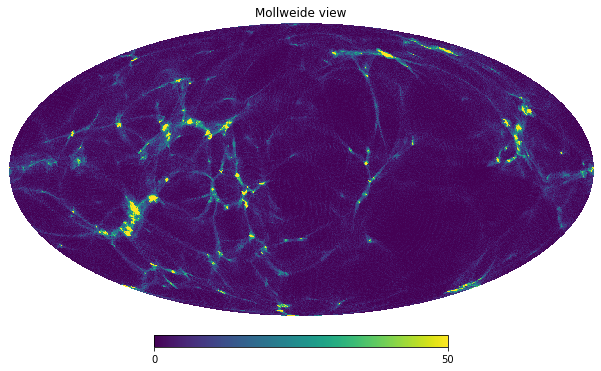

In [9]:
numcount = np.sum(outputCount,axis=0)
print(sum(numcount))

n_bar = np.average(numcount)
overdensity = (numcount-n_bar)/n_bar

hp.mollview(numcount,xsize=3200, max=50)

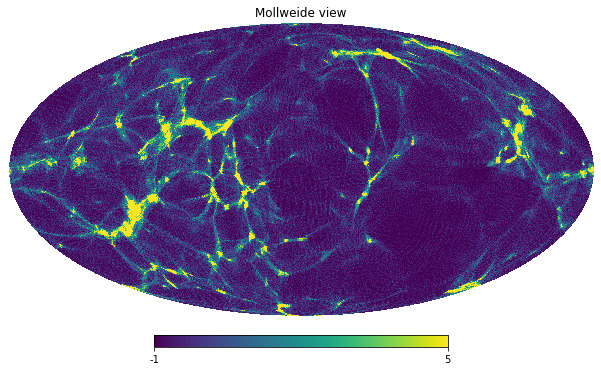

In [10]:
hp.mollview(overdensity,xsize=3200,max=5)

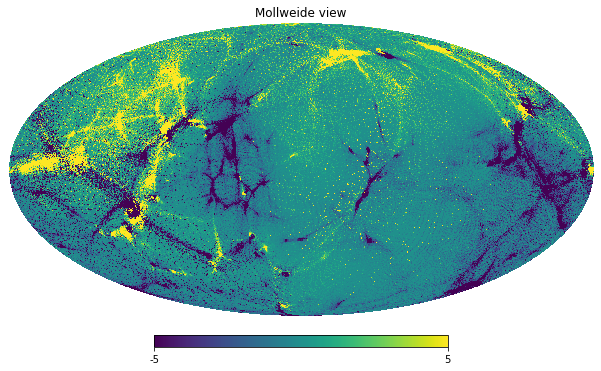

In [21]:
almostkSZ = np.sum(outputSZ,axis=0)
hp.mollview(almostkSZ,xsize=3200,min=-5,max=5)

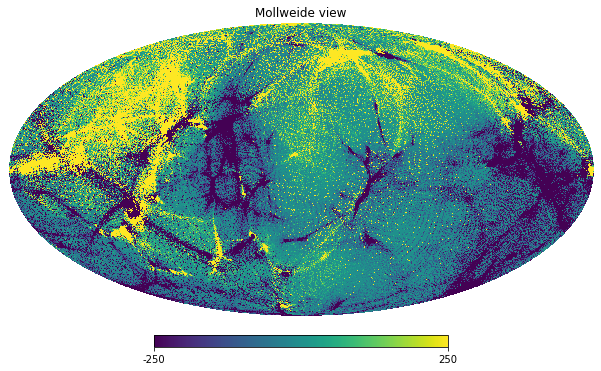

In [22]:
almosterkSZ = almostkSZ/hp.nside2resol(nside)
hp.mollview(almosterkSZ,xsize=3200,min=-250,max=250)

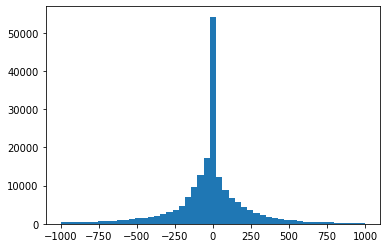

In [23]:
plt.hist(almosterkSZ,bins=np.linspace(-1000,1000));